In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import h5py
import transformations as tf
%matplotlib inline

In [3]:
file = h5py.File('../observations.hdf5', 'r')
points = file['points']
positions = np.array(file['true_positions'])
rotations = np.array(file['true_rotations'])
rgbs = np.array(file['rgb'])
depths = np.array(file['depth'])
print(points.shape)

(660, 76800, 3)


In [4]:
def draw_points(points):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], alpha=0.1)

In [5]:
from tqdm.notebook import tqdm

In [6]:
points_joined = []
rgbs_joined = []
resolution = 0.03
for i in range(len(points)):
    points_hg_coords = np.hstack((points[i], np.ones((len(points[i]), 1))))
    rotation_matrix = tf.quaternion_matrix(rotations[i])
    points_rotated_hg_coords = points_hg_coords @ np.linalg.inv(rotation_matrix)
    points_rotated_hg_coords /= points_rotated_hg_coords[:, -1:]
    points_rotated = points_rotated_hg_coords[:, :-1]
    x, y, z = positions[i]
    points_transformed = points_rotated + np.array([x, y, z])
    points_dst = np.sqrt(points[i, :, 0] ** 2 + points[i, :, 1] ** 2 + points[i, :, 2] ** 2)
    good_point_ids = (points_dst > 0.01)
    points_joined.append(points_transformed[good_point_ids])
    rgbs_joined.append(rgbs[i][good_point_ids])
points_joined = np.vstack(points_joined)
points_joined = np.round(points_joined / resolution) * resolution
rgbs_joined = np.vstack(rgbs_joined)
point_colors = {}
for i, pt in tqdm(enumerate(points_joined)):
    point_colors[tuple(pt)] = rgbs_joined[i]

In [7]:
from collections import Counter
counter = Counter([tuple(x) for x in points_joined])

In [8]:
frequent_points = []
for pt, cnt in counter.items():
    if cnt > 0:
        frequent_points.append(pt)
print(len(frequent_points))

306713


In [9]:
points_joined = np.array(frequent_points)

In [14]:
points_output = open('../rtabmap_fcnn_new/gt_points.txt', 'w')
rgbs_output = open('../rtabmap_fcnn_new/gt_rgbs.txt', 'w')
for pt in tqdm(points_joined):
    print(' '.join([str(x) for x in pt]), file=points_output)
    rgb = point_colors[tuple(pt)]
    print(' '.join([str(x) for x in rgb]), file=rgbs_output)
points_output.close()
rgbs_output.close()

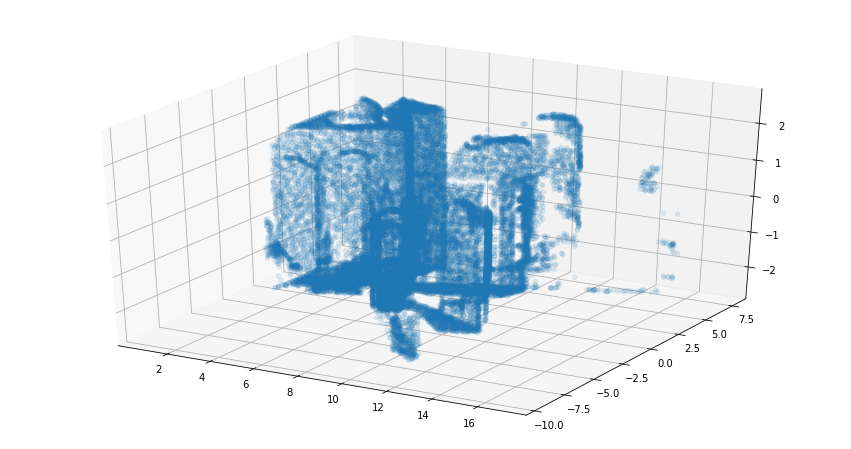

In [12]:
draw_points(points_joined[::10])

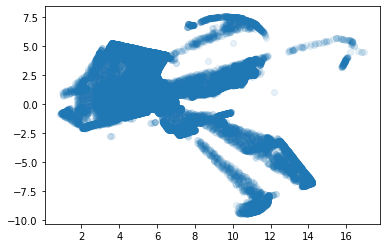

In [13]:
plt.scatter(points_joined[::10, 0], points_joined[::10, 1], alpha=0.1)

In [17]:
import numpy as np
points = np.loadtxt('../rtabmap_fcnn_new/gt_points.txt')

In [16]:
points_output = open('../rtabmap_fcnn_new/points.pcd', 'w')
from tqdm import tqdm_notebook
points_output.write("""VERSION .5
FIELDS x y z
SIZE 4 4 4
TYPE F F F
COUNT 1 1 1
WIDTH {}
HEIGHT 1
POINTS {}
DATA ascii
""".format(len(points), len(points)))
for pt in tqdm_notebook(points):
    print(' '.join([str(x) for x in pt]), file=points_output)
points_output.close()

In [18]:
import numpy as np
slam_points = np.loadtxt('../rtabmap_kinect/slam_points.txt')

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

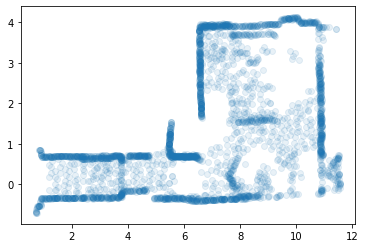

In [20]:
plt.scatter(slam_points[::10, 0], slam_points[::10, 1], alpha=0.1)